## Functionality 3 - Shortest Ordered Route 

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import json
import time
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [11]:
class Relation:
    def __init__(self, type_relation, time, source, target, weight):
        self.type_relation_ = type_relation
        self.time_ = time
        self.source_ = source.get_ID
        self.target_ = target.get_ID
        self.weight_ = weight

    @property
    def get_type(self):
        return self.type_relation_
    
    @property
    def time(self):
        return self.time_
    
    @property
    def target(self):
        return self.target_
    
    @property
    def source(self):
        return self.source_
    
    @property
    def weight(self):
        return self.weight_
    
    def set_weight(self, weight):
        self.weight_ = weight
    
    def __str__(self): 
        return "{\"type_relation\": \"" + self.type_relation_ + "\", \"time\": " + str(self.time_) + ", \"source\": " + str(self.source_) + ", \"target\": " + \
        str(self.target_) + ", \"weight\": "+ str(self.weight_) + "}"
    
    def __repr__(self): 
        return self.__str__()
    
    
     

class User:
    def __init__(self, ID_user):
        self.ID_user = ID_user
        self.in_relation = dict()
        self.out_relation = dict()

    def add_in_relation(self, in_relation):
        if in_relation.time in self.in_relation:
            if in_relation.get_type not in self.in_relation[in_relation.time]:
                self.in_relation[in_relation.time][in_relation.get_type] = []
        else:
            self.in_relation[in_relation.time] = {in_relation.get_type: []}
        self.in_relation[in_relation.time][in_relation.get_type].append(in_relation)

    
    def add_out_relation(self, out_relation):
        if out_relation.time in self.out_relation:
            if out_relation.get_type not in self.out_relation[out_relation.time]:
                self.out_relation[out_relation.time][out_relation.get_type] = []
        else:
            self.out_relation[out_relation.time] = {out_relation.get_type: []}
        self.out_relation[out_relation.time][out_relation.get_type].append(out_relation)
    
    def set_in_relation(inRelations):
        self.in_relation = inRelations
    
    def set_out_relation(outRelation):
        self.out_relation = outRelation

    @classmethod
    def from_json(cls, json):
        return cls(json["ID_user"])
    
    @property
    def get_ID(self):
        return self.ID_user

    @property
    def get_in_relation(self):
        return self.in_relation
    
    @property
    def get_out_relation(self):
        return self.out_relation

    def __str__(self):
        return "{\"in_relation\": " + str(self.in_relation) +  ", \"out_relation\": " + str(self.out_relation) + "}"

    def to_json(self):
        return {"in_relation": self.in_relation, "out_relation":self.out_relation }

    def __repr__(self): 
        return self.__str__()

In [12]:
def create_graph(df, type_node, weight, users):
    for index, row in df.iterrows():
        year_month = int(str(row[2])[:-2])
        source_ = int(row[1])
        target_ = int(row[0])
        source, users = get_user(source_, users)
        target, users = get_user(target_, users)
        rel = Relation(type_node, year_month, source, target, weight)
        users[target_].add_in_relation(rel)
        users[source_].add_out_relation(rel)    
    return users

In [13]:
def get_user(user, dict_users):
    if user not in dict_users:
        user_obj = User(user)
        dict_users[user] = user_obj
    return dict_users[user], dict_users

In [14]:
def getMinUnvisited(unvisited, dist):
    result, dist_min = -1 , float('inf')
    
    aux = {key: dist[key] for key in unvisited}
    return min(aux, key=aux.get)

In [15]:
def getMinUnvisited(unvisited, dist):
    aux = {key: dist[key] for key in unvisited}
    minimum = min(aux.values())
    for key in unvisited:
        if dist[key] == minimum:
            return key

In [16]:
def convertDate(time):
    tmp = time.split("/")
    return int(tmp[1] + tmp[0])

In [17]:
def getShortestPath(source, target, prev, dist):
    path = [target]
    cost = dist[target]
    while target != source:
        path.append(prev[target])
        target = prev[target]
    path.reverse()
    return path, cost

In [18]:
def getNeighbors(node, graph, start, end):
    neighbors = dict()
    x = graph[node].get_out_relation
    for date in x.keys():
        if start <= date <= end:
            for rel in x[date].keys():
                for edge in x[date][rel]:
                    #print(x[date][rel])
                    target = edge.target
                    weight = edge.weight
                    neighbors[target] = neighbors.get(target, weight) + weight
                    #neighbors[] = neighbors[x[date][rel][edge].target].get(x[date][rel][edge], )
                #neighbors.extend([x[date][rel][i].target for i in range(len(x[date][rel]))])
                #neighbors.update([x[date][rel][i].target for i in range(len(x[date][rel]))])
    return neighbors

In [19]:
def overallWeight(graph,source, target,start, end):
    w = 0
    x = graph[source].get_out_relation
    for date in x.keys():
        if start <= date <= end: 
            for rel in x[date].keys():
                for i in range(len(x[date][rel])):
                    if x[date][rel][i].target == target:
                        w += x[date][rel][i].weight
    return w

In [11]:
def myDijkstra(graph, source, start, end):
    start = convertDate(start)
    end = convertDate(end)
    
    visited = set()
    unvisited = set(graph.keys())
    dist = dict()
    prev = dict()
    
    for u in unvisited:
        dist[u] = float('inf')
        prev[u] = -1
    
    dist[source] = 0    
    visited.add(source)

    while len(unvisited) > 0 or not set(neighbor.keys()).issubset(visited): 
        #print(len(unvisited))      
        current_node = getMinUnvisited(unvisited, dist)
         
        unvisited.remove(current_node)
            #print(unvisited, '\n',current_node) 
        visited.add(current_node)
        neighbor = getNeighbors(current_node,graph, start, end)
        
        for u in unvisited.intersection(set(neighbor.keys())):
            new_dist = dist[current_node] + neighbor[u]
            if new_dist < dist[u]:
                dist[u] = new_dist
                prev[u] = current_node      

    return prev, dist

In [12]:
def shortestOrderedRoute(graph, start, end, seq_users, p_1, p_n):
    nodes = [p_1] + seq_users + [p_n]
    path = [p_1]
    weight = 0
    
    for i in range(len(nodes)-1):
        prev, dist = myDijkstra(graph, nodes[i], start, end)
        seq, w = getShortestPath(nodes[i], nodes[i+1], prev, dist)
        if w < float('inf'):
            path.extend(seq[1:])
            weight += w
        else:
            print("It is not possible to find the shortest ordered route because node", nodes[i], "and node", nodes[i+1], "are not connected!")
            return 
    return path, weight

In [3]:
p_1,p_n = 1, 49
orderedRoute = [17]
start = "08/2008"
end = "12/2008"

with open('graph (1).pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [16]:
bestPath, cost = shortestOrderedRoute(graph,start, end,orderedRoute,p_1,p_n)

print("The shortest ordered route between", p_1, "and", p_n,"is:",bestPath, "\nand it costs:", cost)

The shortest ordered route between 1 and 49 is: [1, 49, 17, 49] 
and it costs: 6


## Functionality 2

In [167]:
import networkx as nx

In [210]:
def graph_to_networkx(graph, type_graph): #if type_graph is all, this mean we must to add all type of node
    G = nx.DiGraph()
    for user in graph:
        for year in graph[user].get_out_relation:
            for type_relation in graph[user].get_out_relation[year]:
                if type_relation == type_graph or type_graph.lower() == 'all':
                    for relation in graph[user].get_out_relation[year][type_relation]:
                        G.add_nodes_from([user, relation.target])
                        G.add_edge(user, relation.target, weight=relation.weight, time=year)
    return G

In [159]:
def GetCloseness(graph, source, start, end):
    distances = 0
    keys = set(graph.keys())
    keys.remove((source))
    _, cost = myDijkstra(graph, source, start,end)
    cost = np.array(list(cost.values()))
    position = np.where(cost != float('inf'))[0]
    if sum(cost[position]) == 0: return 0
    return round((len(position) - 1) / sum(cost[position]),3)

In [7]:
with open('graph (1).pickle', 'rb') as handle:
    graph = pickle.load(handle)

In [ ]:
GetCloseness(graph, 3, "08/2008", "01/2009")

In [211]:
g_networkx = graph_to_networkx(graph, 'all')

In [170]:
#nx.closeness_centrality(g_networkx, u=3)
g_networkx.degree()

0.2687837960117196

In [18]:
def degreeCentrality(graph, source, start, end):
    start = convertDate(start)
    end = convertDate(end)
    weight = 0
    g = graph[source].get_out_relation
    for year in g:
        for rel in g[year]:
            for edge in g[year][rel]:
                weight += edge.weight
    return weight/(len(graph)-1)

## Funcionality 4


In [78]:
a2q = pd.read_csv('data/prova.txt',  header=None, sep=' ', quotechar='"', error_bad_lines=False)
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

users = dict()
users = create_graph(a2q, "a2q", 1, users)

In [79]:
users[0].get_out_relation[197001]['a2q'][0].set_weight(6)   #0-1
users[0].get_out_relation[197001]['a2q'][1].set_weight(4)   #0-4

users[1].get_out_relation[197001]['a2q'][0].set_weight(1)   #1-5
users[1].get_out_relation[197001]['a2q'][1].set_weight(3)   #1-2

users[2].get_out_relation[197001]['a2q'][0].set_weight(2)   #2-3

users[3].get_out_relation[197001]['a2q'][0].set_weight(5)   #3-6

users[4].get_out_relation[197001]['a2q'][0].set_weight(3)   #4-1
users[4].get_out_relation[197001]['a2q'][1].set_weight(5)   #4-3

users[5].get_out_relation[197001]['a2q'][0].set_weight(5)   #5-4
users[5].get_out_relation[197001]['a2q'][1].set_weight(1)   #5-3
users[5].get_out_relation[197001]['a2q'][2].set_weight(4)   #5-6

In [13]:
import copy

def createResidualG(graph):
    res = copy.deepcopy(graph)
    for i in range(len(graph)-1):
        x = res[i].get_out_relation[197001]['a2q']
        for j in range(len(x)):
            ty = "a2q"
            d = x[j].time
            s, res = get_user(x[j].target, res)
            t, res = get_user(x[j].source, res)
            w = 0
            rel = Relation(ty, d, s, t, w)
            res[i].add_in_relation(rel)
    return res

In [14]:
def getNeighbors2(node, graph, start, end):
    neighbors = dict()
    x = graph[node].get_out_relation
    for date in x.keys():
        if start <= date <= end:
            for rel in x[date].keys():
                for edge in x[date][rel]:
                    neighbors[edge.target] = edge.weight
    return neighbors

In [15]:
def BFS(graph,s,t,path):
    visited = set()
    queue = [s]
    visited.add(s)
    
    while len(queue)>0:
        v = queue.pop(0)
        neighbor = getNeighbors2(v,graph,197001, 197001)
        for u in set(neighbor.keys()):
            if u not in visited and neighbor[u] > 0:
                queue.append(u)
                visited.add(u)
                path[u] = (v,neighbor[u])
                
    return True if t in visited else False

In [16]:
def getBottleneck(path, source, target):
    current_value = target
    bottleneck = float("inf")
    while current_value != source:
        bottleneck = min(bottleneck, path[current_value][1])
        current_value = path[current_value][0]
    return bottleneck

In [17]:
def updateResGraph(graph,path, flow,s, t):
    walk = [t]
    current_value = t
    while current_value != s:
        walk.append(path[current_value][0])
        current_value = path[current_value][0]
    walk.reverse()
        
    for i in range(len(walk[:-1])):
        el = walk[i] 
        out_ = graph[el].get_out_relation[197001]['a2q']
        for ind in range(len(out_)):
            if out_[ind].target == walk[i+1]:
                w = out_[ind].weight - flow
                out_[ind].set_weight(w)
        
        in_ = graph[el].get_in_relation[197001]['a2q']
        for ind in range(len(in_)):
            if in_[ind].source == walk[i+1]:
                w = in_[ind].weight + flow
                in_[ind].set_weight(w)

In [18]:
def reachFromS(graph, source):
    path = [-1]*(len(graph))
    BFS(graph,source,0, path)
    r = set([i for i in range(len(path)) if path[i] != -1])
    r.add(source)
    return r

In [65]:
def minCut(graph, source, target):
    res = createResidualG(graph)
    max_flow = 0
    path = [-1]*(len(graph))

    while BFS(res,source,target, path):
        bottleneck = getBottleneck(path, source, target)
        max_flow += bottleneck
        updateResGraph(res,path, bottleneck,source,target)
    
    print("Max Flow is:", max_flow)
        
    reachable = reachFromS(res, source) 
    edges = []
    capacity = 0
    
    for v in reachable:
        x = res[v].get_out_relation[197001]['a2q']
        y = graph[v].get_out_relation[197001]['a2q']
        for i in range(len(x)):
            if x[i].weight == 0 and x[i].target not in reachable:
                edges.append((v,x[i].target))
                capacity += y[i].weight 
                
    print("Capacity is:", capacity)
    return edges

In [80]:
print("The edges to cu if we want to disconnect",0, "and", 6, "are:", *minCut(users, 0, 6))

Max Flow is: 7
Capacity is: 7
The edges to cu if we want to disconnect 0 and 6 are: (0, 5) (1, 5) (2, 3)


### ----- new test

In [66]:
a2q = pd.read_csv('data/prova1.txt',  header=None, sep=' ', quotechar='"', error_bad_lines=False)
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

users = dict()
users = create_graph(a2q, "a2q", 1, users)

In [67]:
users[0].get_out_relation[197001]['a2q'][0].set_weight(2)   #0-1
users[0].get_out_relation[197001]['a2q'][1].set_weight(4)   #0-2
users[0].get_out_relation[197001]['a2q'][2].set_weight(1)   #0-3

users[1].get_out_relation[197001]['a2q'][0].set_weight(3)   #1-2
users[1].get_out_relation[197001]['a2q'][1].set_weight(4)   #1-4

users[2].get_out_relation[197001]['a2q'][0].set_weight(3)   #2-3
users[2].get_out_relation[197001]['a2q'][1].set_weight(1)   #2-4

users[3].get_out_relation[197001]['a2q'][0].set_weight(3)   #3-4

In [68]:
print("The edges to cu if we want to disconnect",0, "and", 6, "are:", *minCut(users, 0, 4))

Max Flow is: 6
Capacity is: 6
The edges to cu if we want to disconnect 0 and 6 are: (0, 1) (2, 4) (3, 4)


### ----- new test

In [69]:
a2q = pd.read_csv('data/prova2.txt',  header=None, sep=' ', quotechar='"', error_bad_lines=False)
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

users = dict()
users = create_graph(a2q, "a2q", 1, users)

In [70]:
users[0].get_out_relation[197001]['a2q'][0].set_weight(9)   #0-1
users[0].get_out_relation[197001]['a2q'][1].set_weight(8)   #0-2

users[1].get_out_relation[197001]['a2q'][0].set_weight(4)   #1-3
users[1].get_out_relation[197001]['a2q'][1].set_weight(4)   #1-4

users[2].get_out_relation[197001]['a2q'][0].set_weight(2)   #2-1
users[2].get_out_relation[197001]['a2q'][1].set_weight(3)   #2-5
users[2].get_out_relation[197001]['a2q'][2].set_weight(5)   #2-4

users[3].get_out_relation[197001]['a2q'][0].set_weight(5)   #3-5

users[4].get_out_relation[197001]['a2q'][0].set_weight(6)   #4-5

In [71]:
print("The edges to cu if we want to disconnect",0, "and", 6, "are:", *minCut(users, 0, 5))

Max Flow is: 13
Capacity is: 13
The edges to cu if we want to disconnect 0 and 6 are: (1, 3) (2, 5) (4, 5)


### ----- new test

In [72]:
a2q = pd.read_csv('data/prova3.txt',  header=None, sep=' ', quotechar='"', error_bad_lines=False)
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

users = dict()
users = create_graph(a2q, "a2q", 1, users)

In [73]:
users[0].get_out_relation[197001]['a2q'][0].set_weight(10)   #0-1
users[0].get_out_relation[197001]['a2q'][1].set_weight(10)   #0-3

users[1].get_out_relation[197001]['a2q'][0].set_weight(4)   #1-2
users[1].get_out_relation[197001]['a2q'][1].set_weight(8)   #1-4
users[1].get_out_relation[197001]['a2q'][2].set_weight(2)   #1-3

users[2].get_out_relation[197001]['a2q'][0].set_weight(10)   #2-5

users[3].get_out_relation[197001]['a2q'][0].set_weight(9)   #3-4

users[4].get_out_relation[197001]['a2q'][0].set_weight(6)   #4-2
users[4].get_out_relation[197001]['a2q'][1].set_weight(10)   #4-5

In [74]:
print("The edges to cu if we want to disconnect",0, "and", 6, "are:", *minCut(users, 0, 5))

Max Flow is: 19
Capacity is: 19
The edges to cu if we want to disconnect 0 and 6 are: (0, 1) (3, 4)


### ----- new test

In [75]:
a2q = pd.read_csv('data/prova4.txt',  header=None, sep=' ', quotechar='"', error_bad_lines=False)
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

users = dict()
users = create_graph(a2q, "a2q", 1, users)

In [76]:
users[0].get_out_relation[197001]['a2q'][0].set_weight(10)   #0-1
users[0].get_out_relation[197001]['a2q'][1].set_weight(10)   #0-2

users[1].get_out_relation[197001]['a2q'][0].set_weight(25)   #1-4

users[2].get_out_relation[197001]['a2q'][0].set_weight(15)   #2-3

users[3].get_out_relation[197001]['a2q'][0].set_weight(6)   #3-1
users[3].get_out_relation[197001]['a2q'][1].set_weight(10)   #3-5

users[4].get_out_relation[197001]['a2q'][0].set_weight(10)   #4-5

In [77]:
print("The edges to cu if we want to disconnect",0, "and", 6, "are:", *minCut(users, 0, 5))

Max Flow is: 20
Capacity is: 20
The edges to cu if we want to disconnect 0 and 6 are: (0, 1) (0, 2)


## Visualizzazione 3


In [20]:
import networkx as nx

with open('graph (1).pickle', 'rb') as handle:
    graph = pickle.load(handle)
    
G = networkx_to_subgraph(graph,[1, 49, 17, 49],start = 200808, end = 200812)
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 91\nNumber of edges: 378\nAverage in degree:   4.1538\nAverage out degree:   4.1538'

In [21]:

def graph_to_networkx(graph, type_graph): 
    """
    Trasform the our graph in Networkx object
    
            Parameters:
                    graph (dict): as a key we have the user ID and as a value we have the class associate of the User 
                    type_graph(string): the type of graph that we want to obtain (c2a, c2q, a2q), NOTE: if type_graph is all, this mean we must to add all type of node
    
            Returns:
                    G(networkx): the graph
    
    """

    G = nx.DiGraph()
    for user in graph:
        for year in graph[user].get_out_relation:
            for type_relation in graph[user].get_out_relation[year]:
                if type_relation == type_graph or type_graph.lower() == 'all':
                    for relation in graph[user].get_out_relation[year][type_relation]:
                    #create node
                        G.add_nodes_from([user, relation.target])
                        # create edge
                        G.add_edge(user, relation.target, weight=relation.weight, time=year)
    return G

In [22]:
import random
import math

def networkx_to_subgraph(graph,path, start, end):
    
    # transforming our graph in netwrokx graph
    G = graph_to_networkx(graph, "all")
    perc = 0.3
    nodes = [*set(path)]
    
    for user in path:
        neighbor = list(getNeighbors(user,graph, start, end))
        nodes.extend(random.sample(neighbor,math.ceil(perc * len(neighbor))))
        
    return G.subgraph(nodes)

In [23]:
def getEdges(G, path):
    e1 = []
    e2 = []
    e3 = []   
    edge_path1 = []
    edge_path2 = []
    edge_path3 = []
    
    edge_path = []
    
    for i in range(len(path)-1):
        edge_path.append((path[i],path[i+1]))

    for (x, y, w) in G.edges(data = True):
        if x != y and w["weight"] == 1:
            e1.append((x,y))
            if (x,y) in edge_path:
                edge_path1.append((x,y))             
        elif x != y and w["weight"] == 2:
            e2.append((x,y))
            if (x,y) in edge_path:
                edge_path2.append((x,y))                     
        elif x != y and w["weight"] == 3:
            e3.append((x,y))       
            if (x,y) in edge_path:
                edge_path3.append((x,y))  
                
    return e1, e2, e3, edge_path1, edge_path2, edge_path3

In [58]:
def visualizationGeneralShortestPath(G,path, start, end, k ,seed):
    
    G = networkx_to_subgraph(G,path, start, end)
    plt.figure(figsize = (20,15))

    pos = nx.spring_layout(G, k = k, iterations=20, seed = seed)
    
    nodes = G.nodes
    e1, e2, e3, edge_path1, edge_path2, edge_path3 = getEdges(G, path)
    start_node = path[:1]
    end_node = path[-1:]
    rem = {start_node[0],end_node[0]}
    path = set(path) - rem
    
    nx.draw_networkx_nodes(G, pos, node_size = math.ceil(800*40/len(nodes)), nodelist = set(nodes) - set(path) - rem, alpha = 1, node_color = "white", label = "neighbour nods", edgecolors = "black")
    
    nx.draw_networkx_nodes(G, pos, node_size = math.ceil(1000*50/len(nodes)), nodelist = path, alpha = 0.6, node_color = "orange", label = "path nodes",edgecolors = "darkred")
    
    nx.draw_networkx_nodes(G, pos, node_size = math.ceil(1300*50/len(nodes)), nodelist = start_node,alpha = 0.8, node_color = "gold", label = "start node",edgecolors = "darkorange")
    
    nx.draw_networkx_nodes(G, pos, node_size = math.ceil(1300*50/len(nodes)), nodelist = end_node, alpha = 0.5, node_color = "red", label = "end node",edgecolors = "darkred")
    
    font = math.ceil(25*30/len(nodes)) if len(nodes) > 30 else 18
    labels = nx.draw_networkx_labels(G,pos,{i: i for i in (set(path).union(rem))},font_size = font,font_color='black')

    nx.draw_networkx_edges(G,pos, edgelist = e1, width = round(0.4*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 8, edge_color = "gray", alpha = 1,connectionstyle = "Arc3, rad=0.6" , node_size = math.ceil(1000*50/len(nodes)), label = "ciao" )
    
    nx.draw_networkx_edges(G,pos, edgelist = e2, width = round(0.8*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 8, edge_color = "gray", alpha = 1,connectionstyle = "Arc3, rad=-0.2", node_size = math.ceil(1000*50/len(nodes)), label = "ciao" )
    
    nx.draw_networkx_edges(G,pos, edgelist = e3, width = round(1.2*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 8, edge_color = "gray", alpha = 1,connectionstyle = "Arc3, rad=0.2" , node_size = math.ceil(1000*50/len(nodes)), label = "ciao" )
    
    nx.draw_networkx_edges(G,pos, edgelist = edge_path1, width = round(1.5*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 15, edge_color = "black", alpha = 1,connectionstyle = "Arc3, rad=0.2" , node_size = math.ceil(1400*50/len(nodes)), label = "ciao" )
    
    nx.draw_networkx_edges(G,pos, edgelist = edge_path2, width = round(1.5*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 15, edge_color = "black", alpha = 1,connectionstyle = "Arc3, rad=-0.2" , node_size = math.ceil(1400*50/len(nodes)), label = "ciao" )
    
    nx.draw_networkx_edges(G,pos, edgelist = edge_path3, width = round(1.5*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 15, edge_color = "black", alpha = 1,connectionstyle = "Arc3, rad=0.2" , node_size = math.ceil(1400*50/len(nodes)), label = "ciao" )
    
    plt.axis("off")
    plt.legend(fontsize = 15, markerscale = 0.5)
    plt.show()

In [143]:
def visualizationShortestPath(G,path):
    G = graph_to_networkx(G, "all")
    plt.figure(figsize = (10,8))
    walk = [*range(0,len(path))]
    newG = nx.DiGraph()
    edges = []
    e1 = []
    e2 = []
    e3 = []   
    
    for i in range(len(path[:-1])):
        el1 = path[i]
        el2 = path[i+1]
        for (x, y, w) in G.edges(data = True):
            if x == el1 and y == el2:
                edges.append((i,i+1,w))
                
    newG.add_edges_from(edges)
    
    for (x, y, w) in newG.edges(data = True):
        if x != y and w["weight"] == 1:
            e1.append((x,y))
        elif x != y and w["weight"] == 2:
            e2.append((x,y))             
        elif x != y and w["weight"] == 3:
            e3.append((x,y)) 

    pos = {i : [i%4,i//4] for i in walk}
    
    nx.draw_networkx_nodes(newG, pos, node_size = 1800, nodelist = walk[1:-1], alpha = 0.6, node_color = "orange", label = "path nodes",edgecolors = "darkred")
    
    nx.draw_networkx_nodes(newG, pos, node_size = 2000, nodelist = [0],alpha = 0.8, node_color = "gold", label = "start node",edgecolors = "darkorange")
    
    nx.draw_networkx_nodes(newG, pos, node_size = 2000, nodelist = walk[-1:], alpha = 0.5, node_color = "red", label = "path nodes",edgecolors = "darkred")
    
    labels = nx.draw_networkx_labels(newG,pos,{i: path[i] for i in walk},font_size = 20,font_color='black')

    labels1 = nx.draw_networkx_edge_labels(newG,pos,edge_labels = {i: 1 for i in e1},font_size = 18,font_color='black')
    
    labels2 = nx.draw_networkx_edge_labels(newG,pos,edge_labels = {i: 2 for i in e2},font_size = 18,font_color='black')
    
    labels3 = nx.draw_networkx_edge_labels(newG,pos,edge_labels = {i: 3 for i in e3},font_size = 18,font_color='black')
    
    nx.draw_networkx_edges(G,pos, edgelist = edges, width = 3, arrowstyle = "-|>", arrowsize = 15, edge_color = "black", alpha = 1 , node_size = 2100, label = "ciao" )
    
    plt.axis("off")
    plt.show()

In [128]:
def visualization3(graph,path,start,end,k,seed):
    
    visualizationGeneralShortestPath(graph,path,start,end,k,seed)
    
    visualizationShortestPath(graph,path)

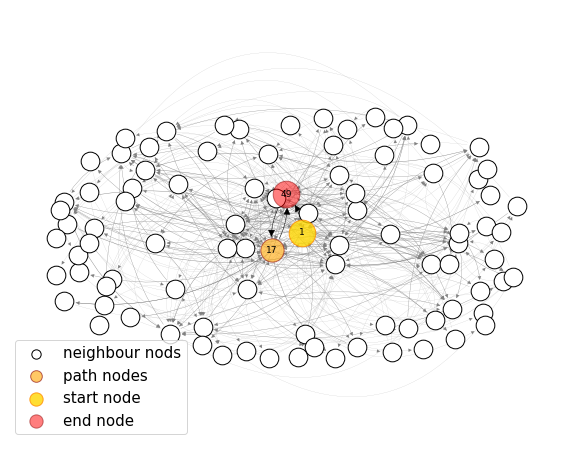

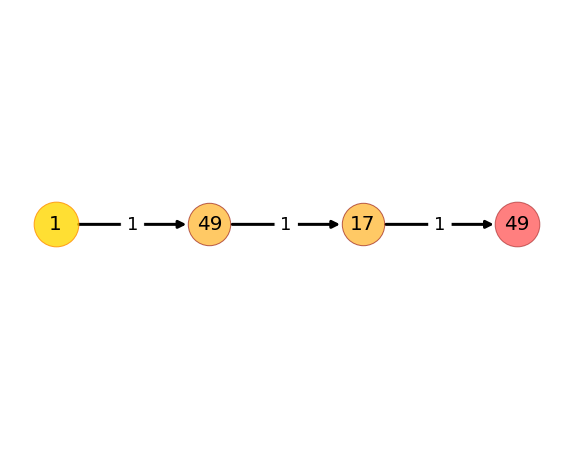

In [132]:
visualization3(graph,[1, 49, 17, 49], 200808, 200812, k = 0.8 ,seed = 125)

In [ ]:
def visualization4(graph, soruce, target, k, seed,cut):
    G = graph_to_networkx(G, "all")
    plt.figure(figsize = (20,15))

    pos = nx.spring_layout(G, k = k, iterations=20, seed = seed)
    
    nodes = G.nodes
    e1, e2, e3, _, _, _ = getEdges(G, [])
    
    nx.draw_networkx_nodes(G, pos, node_size = math.ceil(800*40/len(nodes)), nodelist = set(nodes) - set(source,target), alpha = 1, node_color = "white", label = "neighbour nods", edgecolors = "black")
        
    nx.draw_networkx_nodes(G, pos, node_size = math.ceil(1300*50/len(nodes)), nodelist = [source,target],alpha = 0.8, node_color = "gold", label = "start node",edgecolors = "darkorange")    
    
    font = math.ceil(25*30/len(nodes)) if len(nodes) > 30 else 18
    labels = nx.draw_networkx_labels(G,pos,{i: i for i in [source,target]},font_size = font,font_color='black')

    nx.draw_networkx_edges(G,pos, edgelist = e1, width = round(0.4*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 8, edge_color = "gray", alpha = 1,connectionstyle = "Arc3, rad=0.6" , node_size = math.ceil(1000*50/len(nodes)))
    
    nx.draw_networkx_edges(G,pos, edgelist = e2, width = round(0.8*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 8, edge_color = "gray", alpha = 1,connectionstyle = "Arc3, rad=-0.2", node_size = math.ceil(1000*50/len(nodes)))
    
    nx.draw_networkx_edges(G,pos, edgelist = e3, width = round(1.2*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 8, edge_color = "gray", alpha = 1,connectionstyle = "Arc3, rad=0.2" , node_size = math.ceil(1000*50/len(nodes)))
 
    nx.draw_networkx_edges(G,pos, edgelist = cut, width = round(1.5*30/len(nodes),1), arrowstyle = "-|>", arrowsize = 10, edge_color = "red", alpha = 1,connectionstyle = "Arc3, rad=0.2" , node_size = math.ceil(1400*50/len(nodes)))

    plt.axis("off")
    plt.show()

In [ ]:
pos = {0: [1,0], 1: [0,1], 2: [2,1], 3: [0,2], 4: [2,2], 6: [1,3]}

Then we decided to test our algorithm on the graph we are working on. In order to get a tidier picture we choose to display only the nodes reachable from the source and not the graph in its entirety. 

We can see in this picture that we want to disconnect the two golden nodes wich are : ###### . To do this we run our max flow - min cut algorithm that tells us that if we want to disconnect the two previous nodes, we need to remove only 2 edges that are represented in red, they are: ##########